# Deep Network Training

This notebook trains several neural networks to predict seabirds' dives from GPS data.

Dataset: Guany Cormorants trajectories sampled at 5, 15 and 30s

Network Architecture:

* FCNet : fully connected network (dense layer)
* CNNet : basic convolutional network
* UNet : U-Network with convolutional layers



## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

%cd drive/My\ Drive/THESIS/BirdDL

Mounted at /content/drive/
/content/drive/My Drive/THESIS/BirdDL


## data & libraries

In [ ]:
!pip install pytorch-lightning

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
from utils.dataloader import *
from utils.model import *

In [5]:
data_train = pd.read_csv('./data/LB_train.csv')
data_validation = pd.read_csv('./data/LB_validation.csv')
data_test = pd.read_csv('./data/LB_test.csv')

## Dataset 5s


In [6]:
resolution = 5

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

### FCNet

In [ ]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1304: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name  | Type  | Params
--------------------------------
0 | model | FCNet | 558 K 
--------------------------------
558 K     Trainable params
0         Non-trainable params
558 K     Total params
2.234     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 11min 38s, sys: 3.78 s, total: 11min 41s
Wall time: 11min 38s


0.8715162492632491


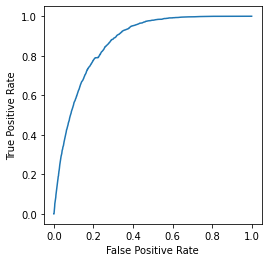

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [7]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

train_set = TrajDataSet(train, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 17min 50s, sys: 7.11 s, total: 17min 57s
Wall time: 17min 57s


0.923651591489758


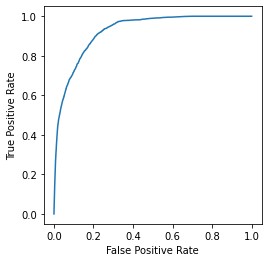

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [ ]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

0.9331292361816356


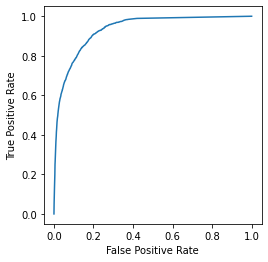

In [9]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [10]:
test.to_csv('./results/LB_'+str(resolution)+'s.csv', index = False)

## Dataset 15s


In [ ]:
resolution = 15

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

### FCNet

In [ ]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5
train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1304: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name  | Type  | Params
--------------------------------
0 | model | FCNet | 558 K 
--------------------------------
558 K     Trainable params
0         Non-trainable params
558 K     Total params
2.234     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 3min 17s, sys: 1.26 s, total: 3min 19s
Wall time: 3min 18s


0.6590596085666482


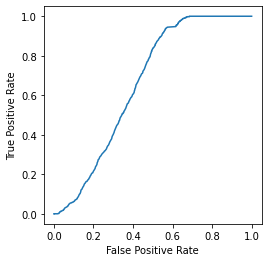

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [ ]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

train_set = TrajDataSet(train, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 8min 56s, sys: 2.97 s, total: 8min 59s
Wall time: 8min 56s


0.8931324869388564


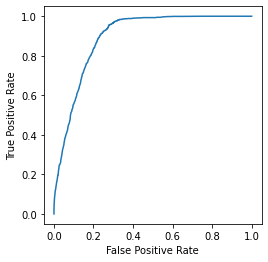

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [ ]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 18.9 K
-------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 8min 57s, sys: 2.89 s, total: 9min
Wall time: 8min 57s


0.9003275855391032


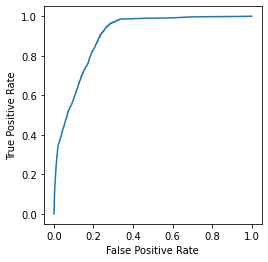

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [ ]:
test.to_csv('./results/LB_'+str(resolution)+'s.csv', index = False)

## Dataset 30s


In [ ]:
resolution = 30

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

### FCNet

In [ ]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5
train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1304: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name  | Type  | Params
--------------------------------
0 | model | FCNet | 558 K 
--------------------------------
558 K     Trainable params
0         Non-trainable params
558 K     Total params
2.234     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 2min 3s, sys: 885 ms, total: 2min 4s
Wall time: 2min 3s


0.6541108421335606


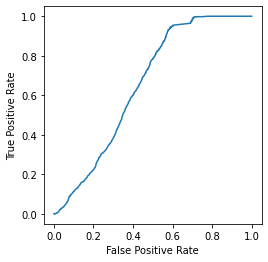

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [ ]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

train_set = TrajDataSet(train, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 3min 14s, sys: 1.13 s, total: 3min 15s
Wall time: 3min 14s


0.743887586995305


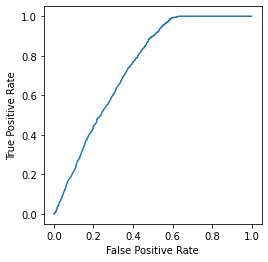

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [ ]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 18.9 K
-------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 4min 21s, sys: 1.5 s, total: 4min 23s
Wall time: 4min 22s


0.8843939994623464


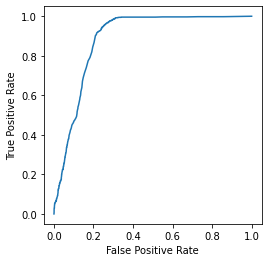

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [ ]:
test.to_csv('./results/LB_'+str(resolution)+'s.csv', index = False)